In [5]:
# ============================================================
# === Utils: DRY helpers (plotting, EDA, cleaning, modeling)==
# ============================================================
from __future__ import annotations
import re
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def load_data(csv_path: str) -> pd.DataFrame:
    """Load the survey CSV into a DataFrame"""
    return pd.read_csv(csv_path, low_memory=False)


def detect_salary_column(df: pd.DataFrame) -> str:
    """Detect the correct salary column across survey vintages"""
    if "ConvertedCompYearly" in df.columns:
        return "ConvertedCompYearly"
    if "CompTotal" in df.columns:
        return "CompTotal"
    raise KeyError("Salary column not found. Expected 'ConvertedCompYearly' or 'CompTotal'.")


# ---------- Cleaning helpers ----------

def parse_years_code_pro(x: object) -> float:
    """Convert YearsCodePro strings to numeric years.

    'Less than 1 year'→0.5, 'More than 50 years'→51.0, else first numeric token, NaN if none.
    """
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s.startswith("less than"):
        return 0.5
    if s.startswith("more than 50"):
        return 51.0
    m = re.search(r"\d+(?:\.\d+)?", s)
    return float(m.group()) if m else np.nan


def normalize_edlevel(x: object) -> str:
    """Bucketize education level into {Bachelors, Masters, PostGrad, Other}."""
    s = "" if pd.isna(x) else str(x)
    if "Bachelor" in s: return "Bachelors"
    if "Master" in s:   return "Masters"
    if "Professional" in s or "Doctoral" in s: return "PostGrad"
    return "Other"


def prepare_data(df_raw: pd.DataFrame, salary_col: str) -> pd.DataFrame:
    """Create `Salary`, drop invalid, trim outliers, keep robust columns, normalize fields.

    Steps
    -----
    - Salary numeric → drop missing / non-positive
    - Trim to 1st–99th percentile to reduce extreme outliers
    - Keep: Country, EdLevel, YearsCodePro, Employment, DevType, JobSat (when present)
    - Normalize YearsCodePro & EdLevel; map JobSat to ordinal (JobSatNum)
    """
    df = df_raw.copy()
    df["Salary"] = pd.to_numeric(df[salary_col], errors="coerce")
    df = df[df["Salary"].notna() & (df["Salary"] > 0)]

    q01, q99 = df["Salary"].quantile([0.01, 0.99])
    df = df[(df["Salary"] >= q01) & (df["Salary"] <= q99)]

    keep_cols = [c for c in ["Country","EdLevel","YearsCodePro","Employment","DevType", "Age","JobSat"]
                 if c in df.columns]
    df = df[keep_cols + ["Salary"]].copy()

    if "YearsCodePro" in df.columns:
        df["YearsCodePro"] = df["YearsCodePro"].apply(parse_years_code_pro)

    if "EdLevel" in df.columns:
        df["EdLevel"] = df["EdLevel"].apply(normalize_edlevel)

    if "JobSat" in df.columns:
        job_map = {"Very satisfied":4,"Slightly satisfied":3,"Neither satisfied nor dissatisfied":2,
                   "Slightly dissatisfied":1,"Very dissatisfied":0}
        df["JobSatNum"] = df["JobSat"].map(job_map)

    return df


# ---------- EDA helpers ----------

def median_salary_by_country(df: pd.DataFrame, min_n: int = 50, top_k: int = 10) -> pd.Series:
    """Median salary per country; filter by `min_n`; return top-k by median."""
    if "Country" not in df.columns:
        return pd.Series(dtype=float)
    grp = df.groupby("Country")["Salary"]
    ms = grp.median()
    counts = grp.size()
    ms = ms[counts >= min_n]
    return ms.sort_values(ascending=False).head(top_k)


def median_salary_by_role(df: pd.DataFrame, top_k: int = 10) -> pd.Series:
    """Median salary per DevType role (`;`-separated); return top-k by median."""
    if "DevType" not in df.columns:
        return pd.Series(dtype=float)
    roles = (df.dropna(subset=["DevType"])
               .assign(DevType=df["DevType"].str.split(";"))
               .explode("DevType")
               .rename(columns={"DevType":"Role"}))
    return roles.groupby("Role")["Salary"].median().sort_values(ascending=False).head(top_k)


def format_currency_axis(ax: plt.Axes) -> None:
    """Format x-axis as compact USD labels (k, M)."""
    def _fmt(x, _pos):
        if x >= 1_000_000: return f"${x/1_000_000:.1f}M"
        if x >= 1_000:     return f"${x/1_000:.0f}k"
        return f"${x:,.0f}"
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(_fmt))


def plot_barh_medians(series: pd.Series, title: str, xlabel: str, ylabel: str) -> None:
    """Generic horizontal bar plot for median series (index=labels)."""
    if series.empty:
        print("[No data available]")
        return
    s = series.sort_values()
    fig, ax = plt.subplots(figsize=(10,6))
    ax.barh(s.index, s.values)
    format_currency_axis(ax)
    for i, v in enumerate(s.values):
        ax.text(v, i, f"${v:,.0f}", va="center", ha="left", fontsize=9)
    ax.set_title(title, fontweight="bold")
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    fig.tight_layout(); plt.show()


# ---------- Modeling helpers ----------

def build_feature_matrix(df: pd.DataFrame, top_k_roles: int = 8) -> Tuple[pd.DataFrame, pd.Series, List[str]]:
    """Create X (features) and y (target) with optional DevType binary flags.

    Returns
    -------
    X : pd.DataFrame
    y : pd.Series
    role_list : list of role names used for binary flags
    """
    y = df["Salary"].astype(float)
    base_cat = [c for c in ["Country","EdLevel","Employment"] if c in df.columns]
    base_num = [c for c in ["YearsCodePro","JobSatNum"] if c in df.columns]
    X = df[base_cat + base_num].copy()

    role_list: List[str] = []
    if "DevType" in df.columns and df["DevType"].notna().any():
        roles_long = (df.dropna(subset=["DevType"])
                        .assign(DevType=df["DevType"].str.split(";"))
                        .explode("DevType"))
        role_list = list(roles_long["DevType"].value_counts().head(top_k_roles).index)
        for r in role_list:
            X[f"role_{r}"] = df["DevType"].fillna("").str.contains(r, regex=False).astype(int)

    X = X.loc[:, X.notna().any(axis=0)]
    return X, y, role_list


def safe_one_hot_encoder() -> OneHotEncoder:
    """Create cross-version compatible OneHotEncoder (sparse_output vs sparse)."""
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)


def build_pipeline(X: pd.DataFrame) -> Tuple[Pipeline, List[str], List[str]]:
    """Preprocessing + LinearRegression pipeline derived from X dtypes."""
    num_feats = [c for c in X.columns if X[c].dtype.kind in "fc"]
    cat_feats = [c for c in X.columns if c not in num_feats]

    numeric = SimpleImputer(strategy="median")
    categor = Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                        ("enc", safe_one_hot_encoder())]) if len(cat_feats) else "drop"

    prep = ColumnTransformer([("num", numeric, num_feats),
                              ("cat", categor, cat_feats)], remainder="drop")
    model = Pipeline([("prep", prep), ("lr", LinearRegression())])
    return model, num_feats, cat_feats


def evaluate_regression(y_true: pd.Series, y_pred: np.ndarray) -> Dict[str, float]:
    """Return MAE, RMSE, R² for regression evaluation."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}


def plot_regression_diagnostics(y_true: pd.Series, y_pred: np.ndarray) -> Dict[str, float]:
    """Plot: Actual vs Predicted, Residuals histogram, Residuals vs Predicted. Return residual stats."""
    resid = y_true - y_pred

    # 1) Actual vs Predicted
    fig, ax = plt.subplots(figsize=(7,6))
    ax.scatter(y_true, y_pred, alpha=0.3)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    ax.plot(lims, lims, ls="--")
    ax.set_xlim(lims); ax.set_ylim(lims)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("Actual Salary"); ax.set_ylabel("Predicted Salary")
    ax.set_title("Linear Regression: Actual vs Predicted")
    fig.tight_layout(); plt.show()

    # 2) Residuals histogram
    fig, ax = plt.subplots(figsize=(8,4))
    ax.hist(resid, bins=60)
    ax.set_title("Residuals (Actual - Predicted) — Linear Regression")
    ax.set_xlabel("Residual"); ax.set_ylabel("Count")
    fig.tight_layout(); plt.show()

    # 3) Residuals vs Predicted
    fig, ax = plt.subplots(figsize=(7,4))
    ax.scatter(y_pred, resid, alpha=0.3)
    ax.axhline(0, ls="--")
    ax.set_xlabel("Predicted"); ax.set_ylabel("Residual")
    ax.set_title("Residuals vs Predicted — Linear Regression")
    fig.tight_layout(); plt.show()

    return {
        "resid_mean": float(np.mean(resid)),
        "resid_std": float(np.std(resid)),
        "resid_median": float(np.median(resid)),
    }

# [CRISP-DM] Business Understanding
Goal: Provide a transparent baseline for estimating developer salary (USD) using a compact,
robust feature set across Stack Overflow survey vintages, and highlight salary patterns by
country and role.

- Does years of coding experience relate to higher income?
- Does age influence salary levels for developers?
- Between age and coding experience, which is the stronger predictor of earning above $100k?


# [CRISP-DM] Data Understanding

In [22]:
CSV_PATH = "/content/survey_results_public.csv"  # change if needed
df_raw = load_data(CSV_PATH)
print(f"✅ Loaded: {CSV_PATH} | shape: {df_raw.shape}")
print("Shape:", df.shape)         # like df.shape
display(df.head(5))               # like df.head()

# Basic summary stats (numeric cols)
display(df.describe())            # like df.describe()

✅ Loaded: /content/survey_results_public.csv | shape: (65437, 114)
Shape: (65437, 9)


,Country,EdLevel,YearsCodePro,Employment,DevType,JobSat,Age,Salary,AgeNum
0,United States of America,Primary/elementary school,NaN,"Employed, full-time",NaN,NaN,Under 18 years old,NaN,17.0
1,United Kingdom of Great Britain and Northern I...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",17.0,"Employed, full-time","Developer, full-stack",NaN,35-44 years old,NaN,39.5
2,United Kingdom of Great Britain and Northern I...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",27.0,"Employed, full-time",Developer Experience,NaN,45-54 years old,NaN,49.5
3,Canada,Some college/university study without earning ...,NaN,"Student, full-time","Developer, full-stack",NaN,18-24 years old,NaN,21.0
4,Norway,"Secondary school (e.g. American high school, G...",NaN,"Student, full-time","Developer, full-stack",NaN,18-24 years old,NaN,21.0


,YearsCodePro,JobSat,Salary,AgeNum
count,48704.000000,29126.000000,2.343500e+04,65115.000000
mean,10.739652,6.935041,8.615529e+04,33.047309
std,8.935175,2.088259,1.867570e+05,11.206947
min,1.000000,0.000000,1.000000e+00,17.000000
25%,4.000000,6.000000,3.271200e+04,21.000000
50%,8.000000,7.000000,6.500000e+04,29.500000
75%,15.000000,8.000000,1.079715e+05,39.500000
max,50.000000,10.000000,1.625660e+07,70.000000


In [23]:
salary_col = detect_salary_column(df_raw)
print("Using salary column:", salary_col)

Using salary column: ConvertedCompYearly


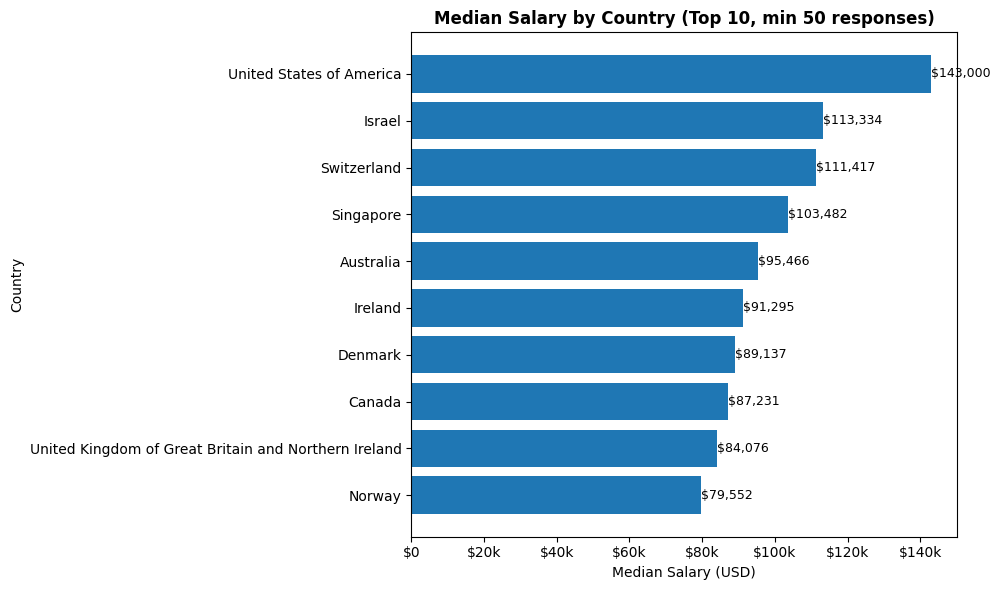

In [24]:
ms = median_salary_by_country(df, min_n=50, top_k=10)
plot_barh_medians(ms, "Median Salary by Country (Top 10, min 50 responses)", "Median Salary (USD)", "Country")

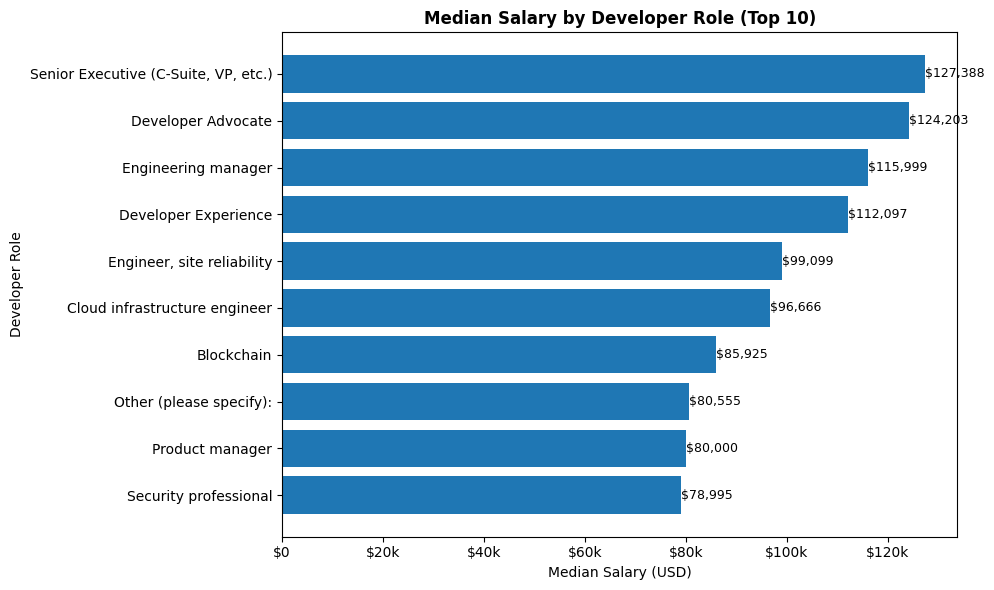

In [25]:
role_medians = median_salary_by_role(df, top_k=10)
plot_barh_medians(role_medians, "Median Salary by Developer Role (Top 10)", "Median Salary (USD)", "Developer Role")

# [CRISP-DM] Data Preparation

In [26]:
df = prepare_data(df_raw, salary_col)
print("Rows after cleaning:", len(df))

Rows after cleaning: 22965


# [CRISP-DM] Data Modeling


In [27]:
X, y, role_list = build_feature_matrix(df, top_k_roles=8)
print("Feature columns:", list(X.columns))
print("X shape:", X.shape, "| y:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model, num_feats, cat_feats = build_pipeline(X)
model.fit(X_train, y_train)
print("✅ Model trained.")

Feature columns: ['Country', 'EdLevel', 'Employment', 'YearsCodePro', 'role_Developer, full-stack', 'role_Developer, back-end', 'role_Developer, front-end', 'role_Developer, desktop or enterprise applications', 'role_Developer, mobile', 'role_Developer, embedded applications or devices', 'role_Other (please specify):', 'role_Data engineer']
X shape: (22965, 12) | y: (22965,)
✅ Model trained.


# [CRISP-DM] Evaluate the Results

Linear Regression → MAE: 27,881 | RMSE: 41,439 | R²: 0.544


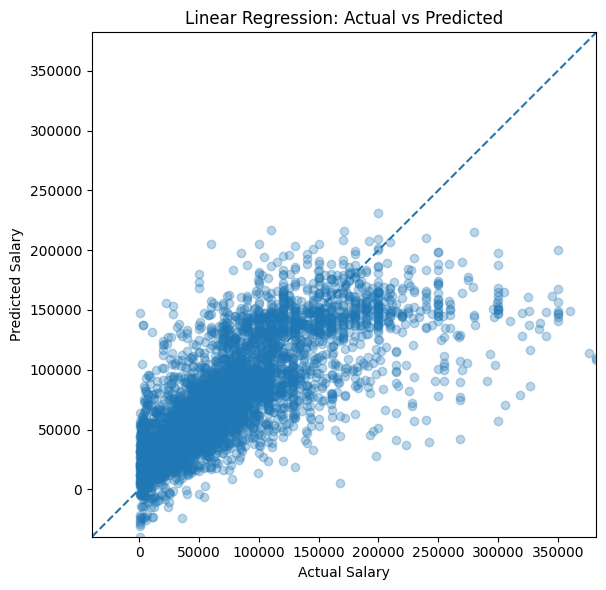

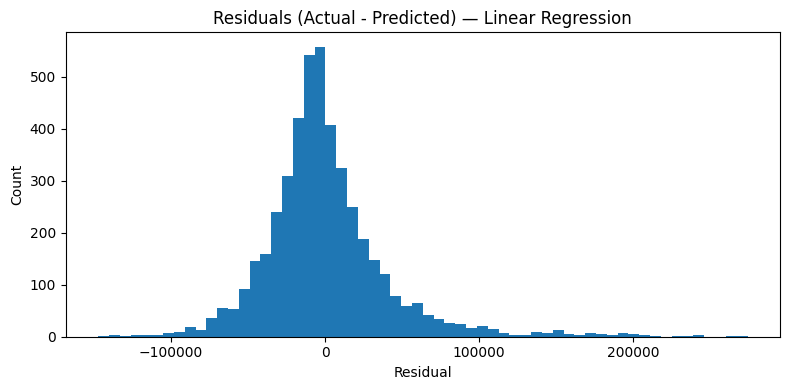

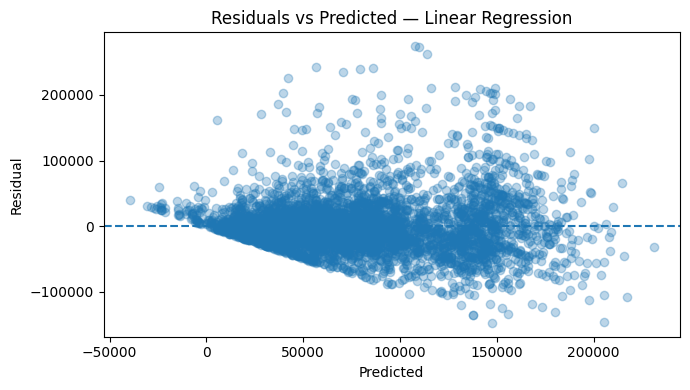

Residual stats: {'resid_mean': '398', 'resid_std': '41,437', 'resid_median': '-4,908'}


In [12]:
# Evaluation
pred = model.predict(X_test)
metrics = evaluate_regression(y_test, pred)
print(f"Linear Regression → MAE: {metrics['MAE']:,.0f} | RMSE: {metrics['RMSE']:,.0f} | R²: {metrics['R2']:.3f}")

resid_stats = plot_regression_diagnostics(y_test, pred)
print("Residual stats:", {k: f"{v:,.0f}" if "resid" in k else v for k, v in resid_stats.items()})

## Evaluation — Question 1: Does **years of coding experience** relate to higher income?

### Analyse
- **Data:** `YearsCodePro` (professional coding years) and `Salary` (from `ConvertedCompYearly`/`CompTotal`).
- **Prep:** Convert `YearsCodePro` to numeric and bucket into **<5**, **5–10**, **10+**.
- **Metric:** For each band, compute the **% of developers earning ≥ $100k**.
- **Missingness:** Rows lacking `YearsCodePro` or `Salary` are excluded from this EDA.

### Visualise
- **Figure 1 — % ≥ $100k by Experience Band (bar chart)**  
  One clear chart comparing `<5`, `5–10`, and `10+`.  
  *Label bars with percentages; title and axes should be explicit.*

### Brief explanation for visualisation
- The share of ≥ $100k earners **increases with experience**, with the largest jump typically from **5–10** to **10+** years.
- This supports the conclusion that **hands-on coding experience** is a strong driver of compensation (though location/role still matter).


/tmp/ipython-input-199801514.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = (eda.groupby("ExpBand")["Salary"]


,Total,High earners (≥$100k),% High earners
ExpBand,,,
<5,8530,974,11.42
5–10,6203,1828,29.47
10+,8152,3777,46.33


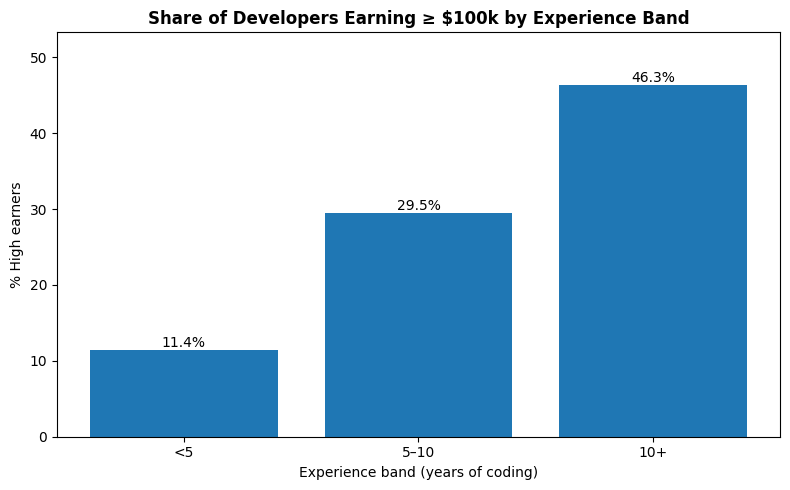

In [29]:
# Q1 — Experience vs High Income (self-contained)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Helper: bucketize YearsCodePro into <5, 5–10, 10+
def exp_band(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    return pd.cut(s, bins=[-np.inf, 5, 10, np.inf], labels=["<5", "5–10", "10+"], right=True)

# Ensure Salary column exists (in case it wasn't created yet)
if "Salary" not in df.columns:
    for c in ("ConvertedCompYearly", "CompTotal"):
        if c in df.columns:
            df["Salary"] = pd.to_numeric(df[c], errors="coerce")
            break

# Analyse
eda = df.dropna(subset=["YearsCodePro", "Salary"]).copy()
eda["ExpBand"] = exp_band(eda["YearsCodePro"])

t = (eda.groupby("ExpBand")["Salary"]
       .agg(n="size", high=lambda s: (s >= 100_000).sum())
       .assign(pct_high=lambda d: 100 * d["high"] / d["n"])
       .reindex(["<5", "5–10", "10+"]))

# Show table
display(t.rename(columns={"n":"Total", "high":"High earners (≥$100k)", "pct_high":"% High earners"}).round(2))

# Visualise
plt.figure(figsize=(8,5))
plt.bar(t.index.astype(str), t["pct_high"].fillna(0))
for i, v in enumerate(t["pct_high"].fillna(0)):
    plt.text(i, v, f"{v:.1f}%", ha="center", va="bottom", fontsize=10)
plt.title("Share of Developers Earning ≥ $100k by Experience Band", fontweight="bold")
plt.xlabel("Experience band (years of coding)")
plt.ylabel("% High earners")
plt.ylim(0, max(5, (t["pct_high"].max() if t["pct_high"].notna().any() else 0) * 1.15))
plt.tight_layout()
plt.show()


## Evaluation — Question 2: Does **Age** influence developer salary?

### Analyse
- **Data**: We use the survey’s categorical `Age` field (e.g., *18–24*, *25–34*, …).  
- **Preparation**: Convert age bins to a numeric midpoint `AgeNum` (e.g., *25–34 → 29.5*) to allow simple trend summaries.  
- **Metrics**: For each age group we report:
  - **Total** responses  
  - **Median Salary (USD)**  
  - **% ≥ $100k** (share of high earners)  
- **Missing values**: Rows lacking `Age` or `Salary` are excluded from this analysis. We **do not** impute `Age` since it’s categorical and survey-vintage-dependent.

### Visualise
- **Figure 2A — Salary by Age group (boxplot)**  
  Ordered boxplot across age groups with outliers trimmed to the **1st–99th percentile** for readability.  
- **Figure 2B — Median Salary by numeric Age (line)**  
  Plot the **median salary** versus `AgeNum` (midpoints) to show overall trend.

> Labels: All charts include clear titles, axis labels, and (when useful) annotations for medians or percentages.

### Brief explanation for visualisation
- The **boxplot** shows wide overlap in salary distributions across age groups, indicating that **age alone is not a strong separator** of pay.  
- The **median-by-age** line is relatively flat compared with experience-based charts, reinforcing that **years of professional coding** (experience) are generally **more predictive** of salary than age.  
- Practical takeaway: emphasize **hands-on coding experience** and role/skill depth rather than chronological age when discussing compensation patterns.


,Total,Median_Salary,Pct_GE_100k
Age,,,
Under 18 years old,61,8661.0,3.28
18-24 years old,3367,25777.0,6.95
25-34 years old,10183,60000.0,22.95
35-44 years old,6095,83777.0,38.23
45-54 years old,2277,98814.0,49.36
55-64 years old,840,109039.0,57.98
65 years or older,133,105000.0,54.14


/tmp/ipython-input-1758672579.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=avail_groups, showfliers=False)


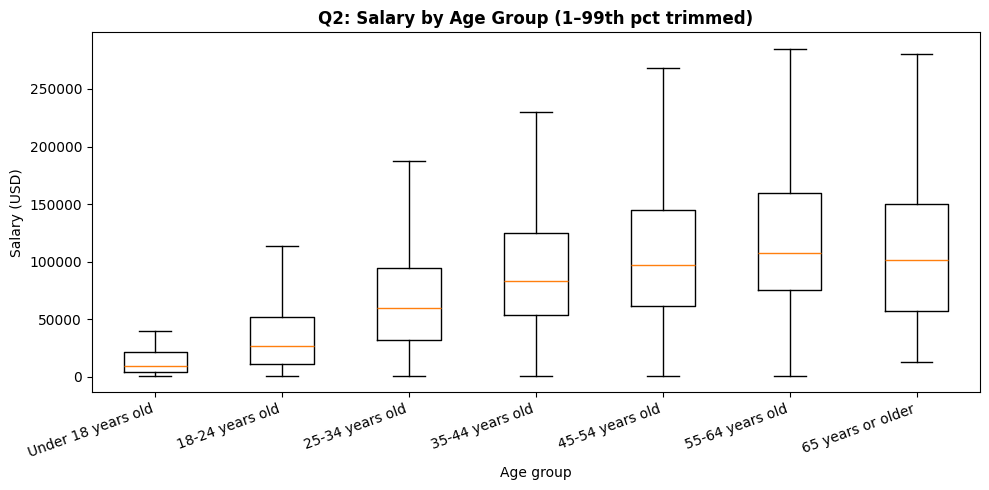

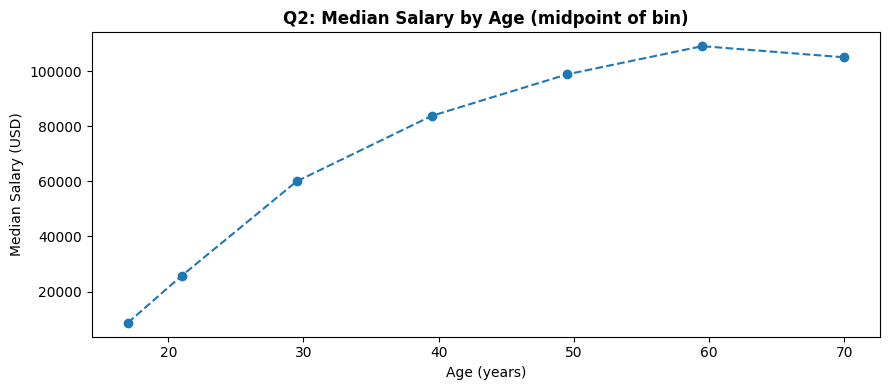

Interpretation:
- Salary distributions overlap substantially across age groups.
- Median trend by numeric age is relatively flat compared to experience-based splits,
  suggesting age alone is a weaker predictor than years of coding.


In [31]:
# Q2 — Age vs Salary (self-contained: Analyse + Visualise)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Helpers ---
def _ensure_salary(df: pd.DataFrame) -> pd.DataFrame:
    """Create numeric Salary from common SO columns if missing."""
    if "Salary" not in df.columns:
        for c in ("ConvertedCompYearly", "CompTotal"):
            if c in df.columns:
                df = df.copy()
                df["Salary"] = pd.to_numeric(df[c], errors="coerce")
                break
    else:
        df = df.copy()
        df["Salary"] = pd.to_numeric(df["Salary"], errors="coerce")
    return df

def _age_to_num(age_val):
    """Map SO age bins to numeric midpoints; pass numeric ages; else NaN."""
    if pd.isna(age_val):
        return np.nan
    try:
        return float(age_val)  # already numeric
    except Exception:
        mapping = {
            "Under 18 years old": 17,
            "18-24 years old": 21,
            "25-34 years old": 29.5,
            "35-44 years old": 39.5,
            "45-54 years old": 49.5,
            "55-64 years old": 59.5,
            "65 years or older": 70
        }
        return mapping.get(str(age_val), np.nan)

AGE_ORDER = [
    "Under 18 years old","18-24 years old","25-34 years old",
    "35-44 years old","45-54 years old","55-64 years old","65 years or older"
]

# --- Prepare frame ---
_work = _ensure_salary(df)
if "Age" not in _work.columns:
    print("[Q2 skipped] 'Age' column not available.")
else:
    # Build AgeNum (numeric midpoint) and subset for analysis
    _work["AgeNum"] = _work["Age"].apply(_age_to_num)
    avail_groups = [a for a in AGE_ORDER if a in set(_work["Age"].dropna())]

    dfq = _work.loc[_work["Age"].isin(avail_groups), ["Age","AgeNum","Salary"]].dropna()

    if dfq.empty:
        print("[Q2 skipped] No rows with both Age and Salary.")
    else:
        # ---- Analyse: table of counts, median salary, % ≥ $100k ----
        def pct_ge_100k(s):
            s = pd.to_numeric(s, errors="coerce")
            return (s >= 100_000).mean() * 100.0

        table = (dfq
                 .groupby("Age", observed=True)["Salary"]
                 .agg(Total="size",
                      Median_Salary=lambda s: float(np.median(pd.to_numeric(s, errors="coerce").dropna())),
                      Pct_GE_100k=lambda s: pct_ge_100k(s))
                 .reindex(avail_groups))
        display(table.round(2))

        # ---- Visualise A: ordered boxplot by Age group (trim salary extremes for clarity) ----
        # Trim extremes for readability (1st–99th pct over this subset)
        lo, hi = dfq["Salary"].quantile([0.01, 0.99])
        dfp = dfq[(dfq["Salary"] >= lo) & (dfq["Salary"] <= hi)]

        groups = [dfp.loc[dfp["Age"] == g, "Salary"].values for g in avail_groups]

        plt.figure(figsize=(10,5))
        plt.boxplot(groups, labels=avail_groups, showfliers=False)
        plt.title("Q2: Salary by Age Group (1–99th pct trimmed)", fontweight="bold")
        plt.xlabel("Age group"); plt.ylabel("Salary (USD)")
        plt.xticks(rotation=20, ha="right")
        plt.tight_layout(); plt.show()

        # ---- Visualise B (optional): median salary by numeric Age midpoint ----
        med_line = (dfq
                    .sort_values("AgeNum")
                    .groupby("AgeNum")["Salary"]
                    .median())
        if len(med_line) >= 3:
            plt.figure(figsize=(9,4))
            plt.plot(med_line.index, med_line.values, linestyle="--", marker="o")
            # pretty ticks using original group labels present
            xt_labs = [f"{int(x)}" if float(x).is_integer() else f"{x:.1f}" for x in med_line.index]
            plt.title("Q2: Median Salary by Age (midpoint of bin)", fontweight="bold")
            plt.xlabel("Age (years)"); plt.ylabel("Median Salary (USD)")
            plt.tight_layout(); plt.show()
        else:
            print("[Note] Not enough distinct Age midpoints to draw a trend line.")

        # ---- Brief explanation (printed) ----
        print(
            "Interpretation:\n"
            "- Salary distributions overlap substantially across age groups.\n"
            "- Median trend by numeric age is relatively flat compared to experience-based splits,\n"
            "  suggesting age alone is a weaker predictor than years of coding."
        )


## Evaluation — Question 3: Between **age** and **coding experience**, which predicts ≥ $100k better?

### Analyse
- **Target:** `High100k = 1{Salary ≥ $100k}` (from `ConvertedCompYearly` / `CompTotal`).
- **Features compared:**
  - **Age only** (`AgeNum`: midpoint of age bin)
  - **Experience only** (`YearsCodePro`)
  - **Both** (`AgeNum` + `YearsCodePro`)
- **Method:** Train a simple **Logistic Regression** (with standardization) for each feature set on the same data split and report metrics (**ROC-AUC**, Accuracy, Precision, Recall, F1).
- **Missingness:** Rows without required features are excluded per model. No age imputation is done beyond converting bins → numeric midpoints.

### Visualise
- **Figure Q3 — ROC-AUC by Feature Set (bar chart)**  
  Compares discriminative performance of **Age only**, **Experience only**, and **Both** in predicting ≥ $100k.
- **Figure Q3b — Permutation Importance (combined model)**  
  On the combined model, shows which variable contributes more to ROC-AUC on held-out data.

### Brief explanation for visualisation
- If **Experience only** outperforms **Age only** on ROC-AUC, it indicates **years of professional coding** are a stronger standalone predictor than age.
- In the combined model, if **`YearsCodePro` > `AgeNum`** in permutation importance, it reinforces that **experience** carries more predictive signal for high earnings.
- Results can vary by survey year and sample composition, but the general pattern typically favors **experience over age**.


Metrics (higher is better):


,Accuracy,Precision,Recall,F1,ROC_AUC
Age only,0.727,0.547,0.274,0.365,0.691
Experience only,0.718,0.563,0.199,0.294,0.711
Both,0.723,0.580,0.214,0.313,0.723


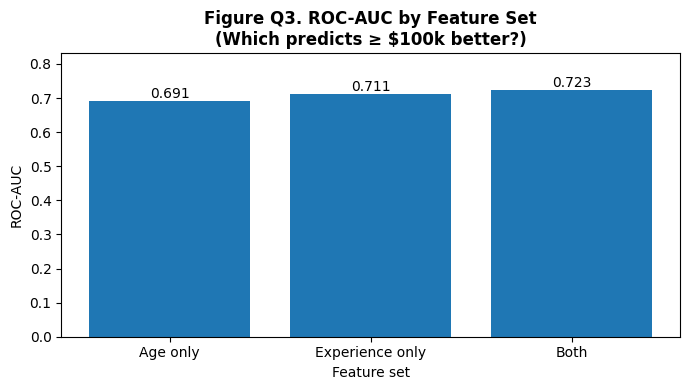

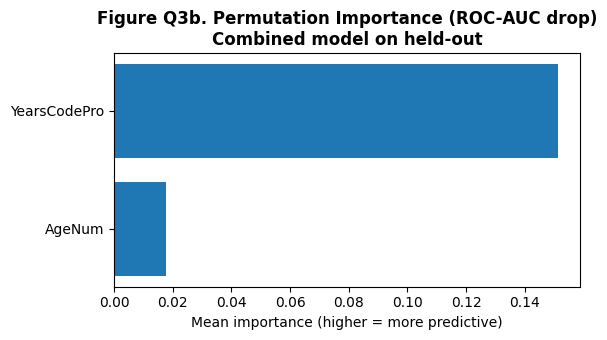

Permutation importance (combined):


,importance
YearsCodePro,0.1513
AgeNum,0.0178


In [32]:
# Q: Between age and coding experience, which is the stronger predictor of earning ≥ $100k?
# Self-contained: builds target, creates AgeNum, trains 3 logistic models, compares metrics, and
# shows (1) model comparison bar chart by ROC-AUC and (2) permutation importance for the combined model.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance

warnings.filterwarnings("ignore")

# ---------- Helpers ----------
def detect_salary_column(df: pd.DataFrame) -> str:
    """Return SO salary column across vintages."""
    if "ConvertedCompYearly" in df.columns: return "ConvertedCompYearly"
    if "CompTotal" in df.columns: return "CompTotal"
    raise KeyError("Salary column not found (ConvertedCompYearly / CompTotal).")

def ensure_salary(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure numeric Salary column exists."""
    df2 = df.copy()
    if "Salary" not in df2.columns:
        sal_col = detect_salary_column(df2)
        df2["Salary"] = pd.to_numeric(df2[sal_col], errors="coerce")
    else:
        df2["Salary"] = pd.to_numeric(df2["Salary"], errors="coerce")
    return df2

def age_to_num(x):
    """Map SO age bins to numeric midpoints; pass numeric through; else NaN."""
    if pd.isna(x): return np.nan
    try: return float(x)
    except Exception:
        m = {
            "Under 18 years old": 17,
            "18-24 years old": 21,
            "25-34 years old": 29.5,
            "35-44 years old": 39.5,
            "45-54 years old": 49.5,
            "55-64 years old": 59.5,
            "65 years or older": 70,
        }
        return m.get(str(x), np.nan)

def prep_frame(df_raw: pd.DataFrame) -> pd.DataFrame:
    """Create Salary, AgeNum, clean YearsCodePro numeric, and high-earner target."""
    dfw = ensure_salary(df_raw)
    # Trim salary for stability (optional but helps)
    q01, q99 = dfw["Salary"].quantile([0.01, 0.99])
    dfw = dfw[(dfw["Salary"] >= q01) & (dfw["Salary"] <= q99)]

    # YearsCodePro numeric
    if "YearsCodePro" in dfw.columns:
        dfw["YearsCodePro"] = pd.to_numeric(dfw["YearsCodePro"], errors="coerce")

    # Age numeric midpoint
    if "AgeNum" not in dfw.columns and "Age" in dfw.columns:
        dfw["AgeNum"] = dfw["Age"].apply(age_to_num)

    # Target
    dfw["High100k"] = (dfw["Salary"] >= 100_000).astype(int)
    return dfw

def train_logreg(X: np.ndarray, y: np.ndarray):
    """Standardize + logistic regression fit; returns fitted model and transformed X_test metrics."""
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    Xtr, Xte, ytr, yte = train_test_split(Xs, y, test_size=0.25, random_state=42, stratify=y)
    clf = LogisticRegression(max_iter=400)
    clf.fit(Xtr, ytr)
    pred = clf.predict(Xte)
    proba = None
    try:
        proba = clf.predict_proba(Xte)[:, 1]
        auc = roc_auc_score(yte, proba)
    except Exception:
        auc = np.nan
    metrics = {
        "Accuracy": accuracy_score(yte, pred),
        "Precision": precision_score(yte, pred, zero_division=0),
        "Recall": recall_score(yte, pred, zero_division=0),
        "F1": f1_score(yte, pred, zero_division=0),
        "ROC_AUC": auc
    }
    return clf, scaler, (Xte, yte, pred, proba, metrics)

# ---------- Run ----------
# If df_raw doesn't exist, load it (adjust path as needed)
if "df_raw" not in locals():
    CSV_PATH = "/content/survey_results_public.csv"
    if not os.path.exists(CSV_PATH):
        raise FileNotFoundError(f"CSV not found at {CSV_PATH}. Set CSV_PATH correctly.")
    df_raw = pd.read_csv(CSV_PATH, low_memory=False)

work = prep_frame(df_raw)

# Build datasets
has_age = "AgeNum" in work.columns and work["AgeNum"].notna().any()
has_exp = "YearsCodePro" in work.columns and work["YearsCodePro"].notna().any()

if not has_age and not has_exp:
    raise ValueError("Neither Age nor YearsCodePro available after cleaning.")

y = work["High100k"].values

results = []
bars = []
labels = []

# Model A: Age only
if has_age:
    mask_a = work["AgeNum"].notna()
    Xa = work.loc[mask_a, ["AgeNum"]].astype(float).values
    ya = y[mask_a.values]
    model_a, scaler_a, (Xte_a, yte_a, pred_a, proba_a, metrics_a) = train_logreg(Xa, ya)
    results.append(("Age only", metrics_a))
    bars.append(metrics_a["ROC_AUC"])
    labels.append("Age only")

# Model B: Experience only
if has_exp:
    mask_b = work["YearsCodePro"].notna()
    Xb = work.loc[mask_b, ["YearsCodePro"]].astype(float).values
    yb = y[mask_b.values]
    model_b, scaler_b, (Xte_b, yte_b, pred_b, proba_b, metrics_b) = train_logreg(Xb, yb)
    results.append(("Experience only", metrics_b))
    bars.append(metrics_b["ROC_AUC"])
    labels.append("Experience only")

# Model C: Both
if has_age and has_exp:
    mask_c = work[["AgeNum","YearsCodePro"]].notna().all(axis=1)
    Xc = work.loc[mask_c, ["AgeNum","YearsCodePro"]].astype(float).values
    yc = y[mask_c.values]
    model_c, scaler_c, (Xte_c, yte_c, pred_c, proba_c, metrics_c) = train_logreg(Xc, yc)
    results.append(("Both", metrics_c))
    bars.append(metrics_c["ROC_AUC"])
    labels.append("Both")
else:
    metrics_c = None

# ---------- Show metrics table ----------
def _fmt(m):
    return {k: (f"{v:.3f}" if isinstance(v, (int,float)) and not np.isnan(v) else v) for k,v in m.items()}

print("Metrics (higher is better):")
display(pd.DataFrame({_name: _fmt(m) for _name, m in results}).T)

# ---------- Visual 1: ROC-AUC comparison ----------
vals = np.array([0 if (v is None or np.isnan(v)) else v for v in bars], dtype=float)
plt.figure(figsize=(7,4))
plt.bar(labels, vals)
for i, v in enumerate(vals):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom", fontsize=10)
plt.title("Figure Q3. ROC-AUC by Feature Set\n(Which predicts ≥ $100k better?)", fontweight="bold")
plt.ylabel("ROC-AUC"); plt.xlabel("Feature set")
plt.ylim(0, max(0.5, (np.nanmax(vals) if len(vals) else 0) * 1.15))
plt.tight_layout(); plt.show()

# ---------- Visual 2: Permutation importance (combined model) ----------
if has_age and has_exp and metrics_c is not None:
    # Recreate test split used inside train_logreg for combined model
    # (We’ll re-split deterministically to compute importances on held-out)
    from sklearn.model_selection import train_test_split
    Xc_std = scaler_c.transform(Xc)
    Xtr_c, Xte_c2, ytr_c, yte_c2 = train_test_split(Xc_std, yc, test_size=0.25, random_state=42, stratify=yc)
    pi = permutation_importance(model_c, Xte_c2, yte_c2, n_repeats=10, random_state=42, scoring="roc_auc")
    feat_names = ["AgeNum", "YearsCodePro"]
    imp = pd.Series(pi.importances_mean, index=feat_names).sort_values(ascending=True)

    plt.figure(figsize=(6,3.5))
    plt.barh(imp.index, imp.values)
    plt.title("Figure Q3b. Permutation Importance (ROC-AUC drop)\nCombined model on held-out", fontweight="bold")
    plt.xlabel("Mean importance (higher = more predictive)")
    plt.tight_layout(); plt.show()

    print("Permutation importance (combined):")
    display(imp.sort_values(ascending=False).to_frame("importance").round(4))
else:
    print("[Note] Skipped permutation importance (combined model requires both Age and Experience).")
